## 1. LSTM 주가예측하기

In [ ]:
# 네이버 금융 주가 크롤링 → 데이터셋 → PyTorch 학습 준비

In [ ]:
# 네이버 금융에서 주가(SK하이닉스) 데이터 크롤링

In [ ]:
# # 7. LSTM 모델 정의
# input_size=1: 한 시점에 입력하는 특징 수가 1개 (예: 종가만 사용)
# hidden_size=50: LSTM 셀의 출력 차원 (은닉 상태 크기)
# batch_first=True: 입력 텐서 형식이 (batch, seq_len, feature) 형식임을 명시

# 출력층 (Fully Connected Layer)
# self.fc = nn.Linear(50, 1) : LSTM의 마지막 은닉 상태(50차원)를 받아, 1개의 수치(예: 다음날 종가) 로 예측

# 순전파 함수 (forward)
# def forward(self, x):
#     out, _ = self.lstm(x)         # out: (batch, seq_len, hidden_size)
#     out = self.fc(out[:, -1])     # 마지막 타임스텝의 출력만 사용
#     return out
# LSTM의 모든 시점 출력을 받아서 out[:, -1]로 마지막 시점의 출력만 추출
# 이후 FC 층을 통해 최종 예측값 반환

C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\4130779599.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\4130779599.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\4130779599.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\4130779599.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and w

[Epoch 0] Loss: 0.012222
[Epoch 10] Loss: 0.008904
[Epoch 20] Loss: 0.007843
[Epoch 30] Loss: 0.006943
[Epoch 40] Loss: 0.005709
[Epoch 50] Loss: 0.003140
[Epoch 60] Loss: 0.001349
[Epoch 70] Loss: 0.000715
[Epoch 80] Loss: 0.000510
[Epoch 90] Loss: 0.000499


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


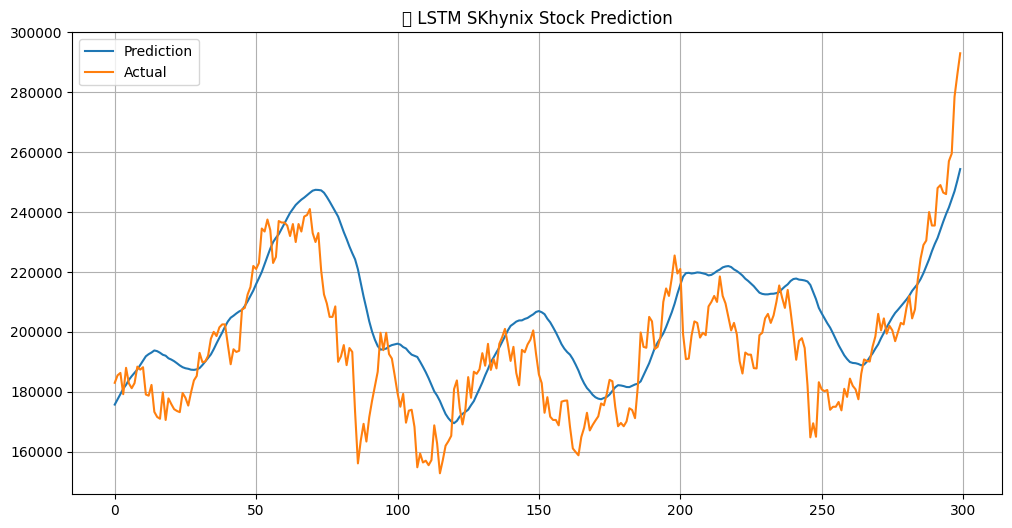

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import datetime

# 1. 네이버 금융에서 주가 데이터 크롤링
def get_stock_data_naver(code, max_pages=50):
    base_url = f"https://finance.naver.com/item/sise_day.naver?code={code}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    df = pd.DataFrame()
    
    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        res = requests.get(url, headers=headers)
        html = BeautifulSoup(res.text, 'lxml')
        table = pd.read_html(str(html.select("table")))[0]
        df = pd.concat([df, table], ignore_index=True)

    df = df.dropna()
    df = df.rename(columns={"날짜": "Date", "종가": "Close"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]].sort_values("Date").reset_index(drop=True)
    return df

# 2. 데이터 로드
stock_code = "000660"  # 예:SK 하이닉스
df = get_stock_data_naver(stock_code, max_pages=100)

# 3. 정규화
scaler = MinMaxScaler()
df["Scaled"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# 4. 시계열 데이터셋 생성
# Sliding window 방식:  과거 일정 기간 데이터를 묶어 하나의 입력으로 사용하고, 그 다음 값을 예측 대상
# window_size: 과거 몇 개의 데이터를 하나의 입력으로 사용할지 설정 (예: 20일)
def make_dataset(data, window_size=20):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_all, y_all = make_dataset(df["Scaled"].values)

# 5. 훈련/테스트 분할
# split = -300 : Python 슬라이싱에서 -300은 뒤에서 300번째 인덱스를 의미
# 앞쪽 데이터 [:split] → 훈련 데이터
# X_all[split:] → 테스트 데이터 
# 즉, 전체 데이터 중에서 마지막 300개를 테스트용

split = -300
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# 6. 텐서 변환
X_train = torch.from_numpy(X_train).float().unsqueeze(2)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float().unsqueeze(2)
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 7. LSTM 모델 정의
# self.fc = nn.Linear(50, 1) : LSTM의 마지막 은닉 상태(50차원)를 받아, 1개의 수치(예: 다음날 종가) 로 예측
class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out

# 8. 모델 학습
# 손실 함수 (Loss Function) 정의: MSELoss: 평균제곱오차(Mean Squared Error)
# Adam: 모멘텀 + 적응 학습률이 결합된 효과적인 옵티마이저
# model.parameters(): 학습 대상인 모든 파라미터들을 옵티마이저에 전달
# lr=0.001: 학습률(learning rate)

model = StockLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#학습 루프를 실행
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.6f}")

# 9. 예측 및 시각화
model.eval()
pred = model(X_test).detach().numpy()
true = y_test.numpy()

# 역정규화 :정규화된 예측값과 실제값을 원래의 주가 스케일로 되돌리고, 이를 시각화하기 위한 필수 단계
# GRU 모델이 예측한 값은 MinMaxScaler로 0~1 범위로 정규화된 값입니다.
# 예측된 pred 값을 정규화 이전의 실제 주가 값으로 되돌리는 것입니다.
pred = scaler.inverse_transform(pred)
true = scaler.inverse_transform(true)

plt.figure(figsize=(12,6))
plt.plot(pred, label='Prediction')
plt.plot(true, label='Actual')
plt.legend()
plt.title("📈 LSTM SKhynix Stock Prediction")
plt.grid()
plt.show()


#### 최근 1개월 SK하이닉스 주가 데이터를 기반으로 LSTM 모델이 예측한 향후 10일간의 주가 예측 결과

C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and w

[Epoch 0] Loss: 0.364149
[Epoch 10] Loss: 0.216803
[Epoch 20] Loss: 0.077602
[Epoch 30] Loss: 0.049617
[Epoch 40] Loss: 0.032152
[Epoch 50] Loss: 0.032474
[Epoch 60] Loss: 0.029856
[Epoch 70] Loss: 0.027844
[Epoch 80] Loss: 0.026255
[Epoch 90] Loss: 0.024318

📈 향후 10일간 SK하이닉스 주가 예측:
        Date  Predicted Close
0 2025-06-27    271493.199646
1 2025-06-30    273647.988915
2 2025-07-01    275525.428653
3 2025-07-02    277048.044771
4 2025-07-03    278447.236180
5 2025-07-04    279781.761229
6 2025-07-07    281011.856884
7 2025-07-08    281949.695826
8 2025-07-09    282770.566672
9 2025-07-10    283208.403140


C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\1946889110.py:115: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()

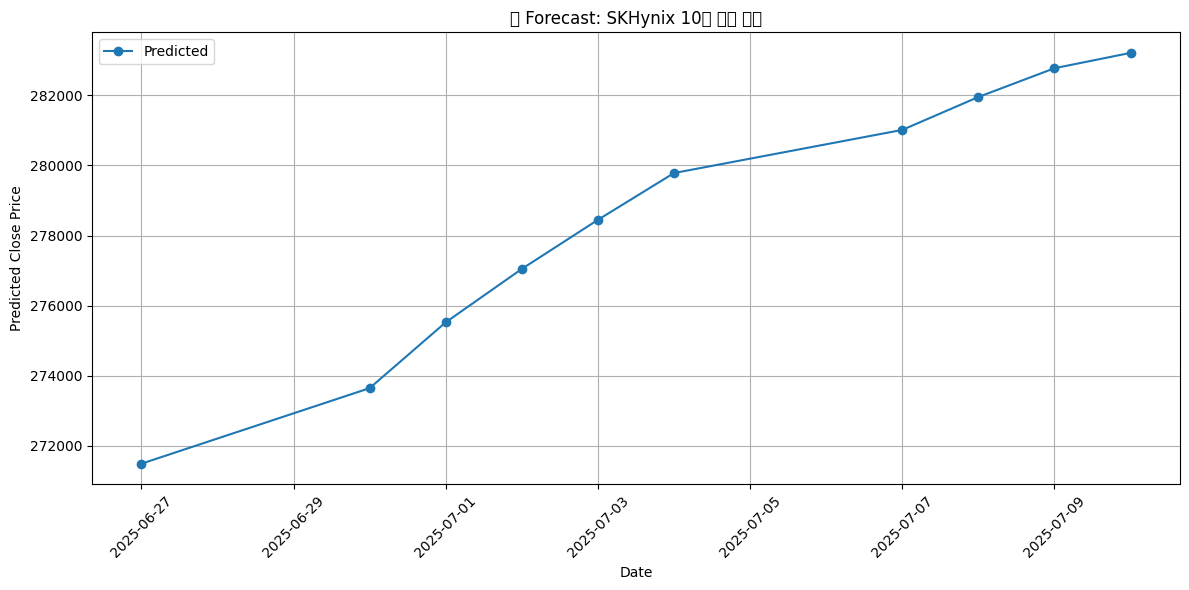

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import datetime

# 1. 네이버 금융에서 주가 데이터 크롤링 함수
def get_stock_data_naver(code, max_pages=10):
    base_url = f"https://finance.naver.com/item/sise_day.naver?code={code}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    df = pd.DataFrame()

    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        res = requests.get(url, headers=headers)
        html = BeautifulSoup(res.text, 'lxml')
        table = pd.read_html(str(html.select("table")))[0]
        df = pd.concat([df, table], ignore_index=True)

    df = df.dropna()
    df = df.rename(columns={"날짜": "Date", "종가": "Close"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]].sort_values("Date").reset_index(drop=True)
    return df

# 2. 최근 1개월 데이터 가져오기
today = datetime.datetime.today()
one_month_ago = today - datetime.timedelta(days=30)
stock_code = "000660"  # SK하이닉스
df = get_stock_data_naver(stock_code, max_pages=10)
df = df[df["Date"] >= one_month_ago]

# 3. 정규화
scaler = MinMaxScaler()
df["Scaled"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# 4. 시계열 데이터셋 생성 함수
def make_dataset(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_all, y_all = make_dataset(df["Scaled"].values)
X_train, y_train = X_all, y_all

# 5. 텐서 변환
X_train = torch.from_numpy(X_train).float().unsqueeze(2)  # (samples, seq_len, 1)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)  # (samples, 1)

# 6. LSTM 모델 정의
class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])  # 마지막 타임스텝 출력
        return out

# 7. 모델 학습
model = StockLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.6f}")

# 8. 향후 10일 예측
model.eval()
future_pred = []
input_seq = X_train[-1].unsqueeze(0).clone()  # shape: (1, seq_len, 1)

for _ in range(10):
    with torch.no_grad():
        next_val = model(input_seq)  # shape: (1, 1)
    future_pred.append(next_val.item())
    next_input = next_val.view(1, 1, 1)  # shape: (1, 1, 1)
    input_seq = torch.cat((input_seq[:, 1:, :], next_input), dim=1)

# 9. 예측 결과 시각화 및 출력
predicted_10 = scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))
future_dates = pd.date_range(start=df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=10, freq="B")
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Close": predicted_10.flatten()})

# 예측 결과 출력
print("\n📈 향후 10일간 SK하이닉스 주가 예측:")
print(forecast_df)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(forecast_df["Date"], forecast_df["Predicted Close"], marker='o', label='Predicted')
plt.title("📉 Forecast: SKHynix 10일 주가 예측")
plt.xlabel("Date")
plt.ylabel("Predicted Close Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 결과 요약
# 예측 결과 요약
# 날짜	예측 종가 (원)
# 2025-06-27	271,493
# 2025-06-30	273,648
# 2025-07-01	275,525
# 2025-07-02	277,048
# 2025-07-03	278,447
# 2025-07-04	279,782
# 2025-07-07	281,012
# 2025-07-08	281,950
# 2025-07-09	282,771
# 2025-07-10	283,208

# 1. 우상향 추세
# 예측된 주가는 전반적으로 지속적인 상승세를 보이고 있습니다.
# 10일간 약 11,700원 이상 상승하는 것으로 나타나며, 이는 LSTM이 최근의 상승 흐름을 계속될 것으로 학습했음을 의미합니다.
# 2. 변동성
# 상승률은 초기에는 상대적으로 완만하다가, 중후반으로 갈수록 약간씩 둔화되는 모습입니다.
# 예측 오차가 누적될 수 있으므로 후반일수록 신뢰 구간은 넓게 해석하는 것이 좋습니다.
# 3. 모델 해석 주의사항
# 모델은 과거 가격 패턴을 학습해 미래를 예측하는 구조로, 시장 이벤트, 뉴스, 실적 발표 등은 반영하지 않습니다.

## 2. GRU

### GRU 기반 주가 예측 (네이버 크롤링 + MinMax 정규화)

In [ ]:
# 모델	nn.GRU 사용 (LSTM보다 계산 가볍고 빠름)
# 학습 목표	과거 20일 종가로 다음날 예측
# 출력	plt.plot()으로 실제 vs 예측 시각화


C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and w

[Epoch 0] Loss: 0.013194
[Epoch 10] Loss: 0.008392
[Epoch 20] Loss: 0.006939
[Epoch 30] Loss: 0.005750
[Epoch 40] Loss: 0.004434
[Epoch 50] Loss: 0.002531
[Epoch 60] Loss: 0.000357
[Epoch 70] Loss: 0.000347
[Epoch 80] Loss: 0.000404
[Epoch 90] Loss: 0.000318


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


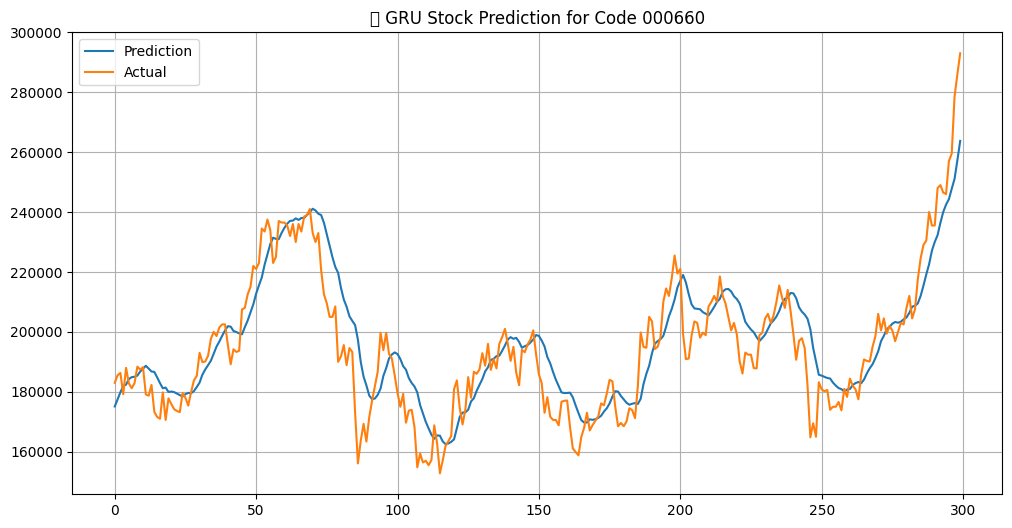

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# 1. 네이버에서 주가 크롤링 함수
def get_stock_data_naver(code, max_pages=50):
    base_url = f"https://finance.naver.com/item/sise_day.naver?code={code}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    df = pd.DataFrame()
    
    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        res = requests.get(url, headers=headers)
        html = BeautifulSoup(res.text, 'lxml')
        table = pd.read_html(str(html.select("table")))[0]
        df = pd.concat([df, table], ignore_index=True)

    df = df.dropna()
    df = df.rename(columns={"날짜": "Date", "종가": "Close"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]].sort_values("Date").reset_index(drop=True)
    return df

# 2. 데이터 로드 및 정규화
code = "000660"  # SK하이닉스
df = get_stock_data_naver(code, max_pages=100)

scaler = MinMaxScaler()
df["Scaled"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# 3. 시계열 데이터 생성
def make_dataset(data, window_size=20):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_all, y_all = make_dataset(df["Scaled"].values)
split = -300
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# 4. 텐서 변환
X_train = torch.from_numpy(X_train).float().unsqueeze(2)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float().unsqueeze(2)
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 5. GRU 모델 정의
class StockGRU(nn.Module):
    def __init__(self):
        super(StockGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1])
        return out

# 6. 학습 준비
model = StockGRU()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.6f}")

# 8. 예측 및 시각화
model.eval()
pred = model(X_test).detach().numpy()
true = y_test.numpy()

# 역정규화
pred = scaler.inverse_transform(pred)
true = scaler.inverse_transform(true)

plt.figure(figsize=(12,6))
plt.plot(pred, label='Prediction')
plt.plot(true, label='Actual')
plt.title(f"📈 GRU Stock Prediction for Code {code}")
plt.legend()
plt.grid()
plt.show()


C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(str(html.select("table")))[0]
C:\Users\JYB\AppData\Local\Temp\ipykernel_13732\3320637752.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and w

[Epoch 0] Loss: 0.084031
[Epoch 10] Loss: 0.019482
[Epoch 20] Loss: 0.009678
[Epoch 30] Loss: 0.007868
[Epoch 40] Loss: 0.007129
[Epoch 50] Loss: 0.006479
[Epoch 60] Loss: 0.005904
[Epoch 70] Loss: 0.005348
[Epoch 80] Loss: 0.004772
[Epoch 90] Loss: 0.004131


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


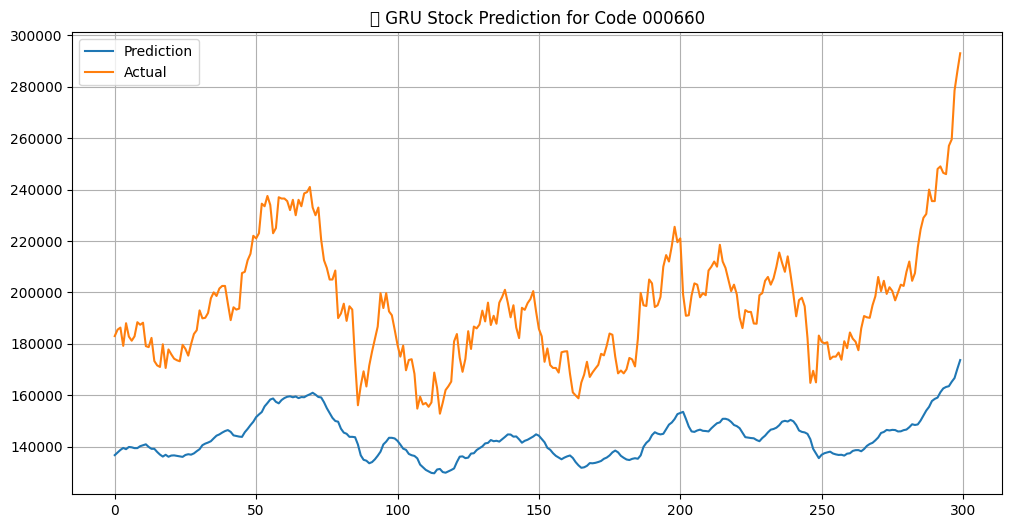

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# 1. 네이버에서 주가 크롤링 함수
def get_stock_data_naver(code, max_pages=50):
    base_url = f"https://finance.naver.com/item/sise_day.naver?code={code}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    df = pd.DataFrame()
    
    for page in range(1, max_pages + 1):
        url = f"{base_url}&page={page}"
        res = requests.get(url, headers=headers)
        html = BeautifulSoup(res.text, 'lxml')
        table = pd.read_html(str(html.select("table")))[0]
        df = pd.concat([df, table], ignore_index=True)

    df = df.dropna()
    df = df.rename(columns={"날짜": "Date", "종가": "Close"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df[["Date", "Close"]].sort_values("Date").reset_index(drop=True)
    return df

# 2. 데이터 로드 및 정규화
code = "000660"  # SK하이닉스
df = get_stock_data_naver(code, max_pages=100)

scaler = MinMaxScaler()
df["Scaled"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

# 3. 시계열 데이터 생성
def make_dataset(data, window_size=20):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X_all, y_all = make_dataset(df["Scaled"].values)
split = -300
X_train, y_train = X_all[:split], y_all[:split]
X_test, y_test = X_all[split:], y_all[split:]

# 4. 텐서 변환
X_train = torch.from_numpy(X_train).float().unsqueeze(2)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float().unsqueeze(2)
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 5. GRU 모델 정의
class StockGRU(nn.Module):
    def __init__(self):
        super(StockGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1])
        return out

# 6. 학습 준비
model = StockGRU()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.6f}")

# 8. 예측 및 시각화
model.eval()
pred = model(X_test).detach().numpy()
true = y_test.numpy()

# 역정규화
pred = scaler.inverse_transform(pred)
true = scaler.inverse_transform(true)

plt.figure(figsize=(12,6))
plt.plot(pred, label='Prediction')
plt.plot(true, label='Actual')
plt.title(f"📈 GRU Stock Prediction for Code {code}")
plt.legend()
plt.grid()
plt.show()
